In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
#load and print the dataset
data = pd.read_csv("cruiseships.csv", sep=";")
data = data.fillna(0)
data = data[data["Name"] != 0]
data = data[data["L"] != 0]
data = data[data["B"] != 0]
data = data[data["T"] != 0]
data = data[data["DW"] != 0]
print(data)

                   Name    L   B  T       DW
0   Antherm of the seas  310  41  9  12000.0
1         Azamara Quest  253  26  6   2700.0
2     Carnival Conquest  348  36  8  10000.0
3      Carnival Destiny  181  35  8  11142.0
4      Carnival Ecstasy  290  31  8   7200.0
..                  ...  ...  .. ..      ...
82              Voyager  330  29  7   5400.0
83  Voyager of the Seas  181  48  8  11132.0
84              Whisper  251  25  6   2980.0
85                 Wind  136  12  7   1790.0
86                Wolin  330  24  6   5143.0

[86 rows x 5 columns]


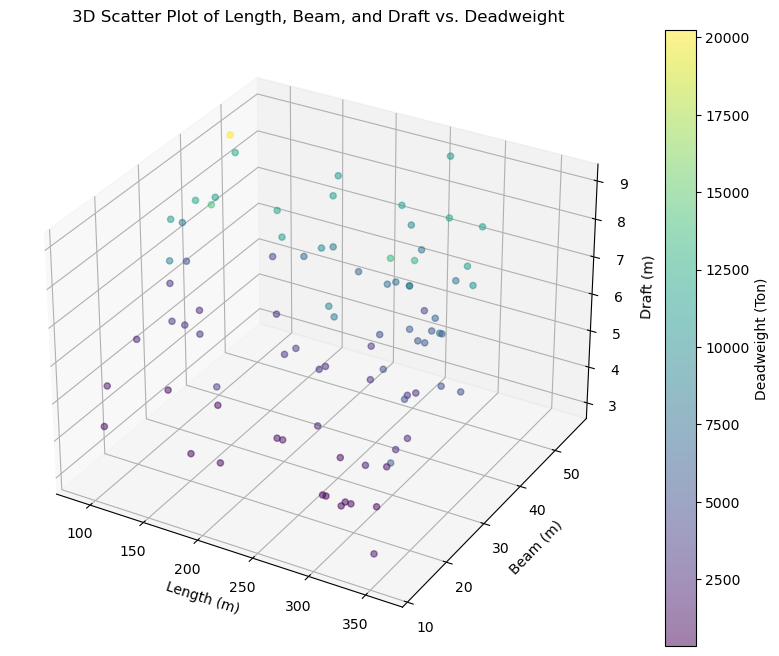

In [3]:
#data preprocessing and cleaning
data = data.drop(columns=['Name'])
data.columns = data.columns.str.replace('[^\w\s]', '')

#plot the data using Matplotlib in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

#scatter plot with "L," "B," and "T" as the 3D dimensions and "DW" as the color scale
scatter = ax.scatter(data['L'], data['B'], data['T'], c=data['DW'], cmap='viridis', marker='o', alpha=0.5)
plt.colorbar(scatter, label='Deadweight (Ton)')

#set labels for the axes and a title
ax.set_xlabel('Length (m)')
ax.set_ylabel('Beam (m)')
ax.set_zlabel('Draft (m)')
plt.title('3D Scatter Plot of Length, Beam, and Draft vs. Deadweight')

#show the plot
plt.grid(True)
plt.show()

In [4]:
#data transformation - scaling
scaler = StandardScaler()

#fit the scaler to your data to compute the mean and standard deviation
scaler.fit(data)

#transform your data using the scaler to scale it
scaled_data = scaler.transform(data)

#calculate the mean and standard deviation for each feature
mean_values = np.mean(scaled_data, axis=0)
std_deviation = np.std(scaled_data, axis=0)

#print the mean and standard deviation for each feature
for i, column in enumerate(data.columns):
    print(f"Feature: {column}")
    print(f"Mean: {mean_values[i]}")
    print(f"Standard Deviation: {std_deviation[i]}\n")


Feature: L
Mean: 1.2264091551091845e-16
Standard Deviation: 1.0

Feature: B
Mean: 2.1946269091427512e-17
Standard Deviation: 1.0

Feature: T
Mean: -2.2075364791965322e-16
Standard Deviation: 1.0

Feature: DW
Mean: -2.872379336966248e-17
Standard Deviation: 1.0



In [5]:
#split the data into training and validation sets
X = data[['L', 'B', 'T']]
y = data['DW']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
#define a range of alpha values to search over
alphas = [0.01, 0.1, 0.5, 1.0, 2.0, 4.0, 6.0, 8.0, 10.0]

#create a lasso regression model
lasso_model = Lasso()

#perform grid search with cross-validation
grid_search = GridSearchCV(lasso_model, param_grid={'alpha': alphas}, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

#get the best alpha value from the grid search
best_alpha = grid_search.best_params_['alpha']
print(f"Optimal Alpha: {best_alpha}")

Optimal Alpha: 10.0


In [7]:
#create and train the Lasso regression model with regularization
lasso_model = Lasso(alpha=best_alpha)
lasso_model.fit(X_train, y_train)

#calculate the L1-norm of parameters (Lasso) for the model
lasso_coefficient_norm = np.sum(np.abs(lasso_model.coef_))
print(f"L1-norm of parameters (Lasso): {lasso_coefficient_norm:.2f}")

L1-norm of parameters (Lasso): 1266.31


In [8]:
#make predictions on the training set
y_train_pred = lasso_model.predict(X_train)

#make predictions on the validation set
y_val_pred = lasso_model.predict(X_val)

In [9]:
#calculate training error metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)

#calculate validation error metrics
val_mae = mean_absolute_error(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, y_val_pred)

#print the evaluation metrics
print("\nLasso regression training error metrics:")
print(f"Mean Absolute Error (MAE): {train_mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {train_rmse:.2f}")
print(f"R-squared (R2): {train_r2:.2f}")

print("\nLasso regression validation error metrics:")
print(f"Mean Absolute Error (MAE): {val_mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {val_rmse:.2f}")
print(f"R-squared (R2): {val_r2:.2f}")


Lasso regression training error metrics:
Mean Absolute Error (MAE): 1604.38
Root Mean Squared Error (RMSE): 2058.96
R-squared (R2): 0.76

Lasso regression validation error metrics:
Mean Absolute Error (MAE): 1125.67
Root Mean Squared Error (RMSE): 1366.67
R-squared (R2): 0.86


In [10]:
#now, let's perform polynomial regression with degrees 2, 3, and 4
degrees = [2, 3, 4]
polyregr_models = {}  #create an empty dictionary to store the models

In [11]:
for degree in degrees:
    #create polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    #create and train a linear regression model on the polynomial features
    polyregr_model = LinearRegression()
    polyregr_model.fit(X_train_poly, y_train)
    
    #store the model in the dictionary
    polyregr_models[f'polyregr_{degree}_model'] = polyregr_model

    #make predictions on the training set
    y_train_pred_poly = polyregr_model.predict(X_train_poly)

    #make predictions on the validation set
    y_val_pred_poly = polyregr_model.predict(X_val_poly)

    #calculate training error metrics for polynomial regression
    train_mae_poly = mean_absolute_error(y_train, y_train_pred_poly)
    train_mse_poly = mean_squared_error(y_train, y_train_pred_poly)
    train_rmse_poly = np.sqrt(train_mse_poly)
    train_r2_poly = r2_score(y_train, y_train_pred_poly)

    #calculate validation error metrics for polynomial regression
    val_mae_poly = mean_absolute_error(y_val, y_val_pred_poly)
    val_mse_poly = mean_squared_error(y_val, y_val_pred_poly)
    val_rmse_poly = np.sqrt(val_mse_poly)
    val_r2_poly = r2_score(y_val, y_val_pred_poly)

    #print the evaluation metrics for polynomial regression
    print(f"Polynomial regression (degree {degree}) training error metrics:")
    print(f"Mean Absolute Error (MAE): {train_mae_poly:.2f}")
    print(f"Root Mean Squared Error (RMSE): {train_rmse_poly:.2f}")
    print(f"R-squared (R2): {train_r2_poly:.2f}")

    print(f"\nPolynomial regression (degree {degree}) validation error metrics:")
    print(f"Mean Absolute Error (MAE): {val_mae_poly:.2f}")
    print(f"Root Mean Squared Error (RMSE): {val_rmse_poly:.2f}")
    print(f"R-squared (R2): {val_r2_poly:.2f}\n")

Polynomial regression (degree 2) training error metrics:
Mean Absolute Error (MAE): 1400.03
Root Mean Squared Error (RMSE): 1759.16
R-squared (R2): 0.83

Polynomial regression (degree 2) validation error metrics:
Mean Absolute Error (MAE): 952.09
Root Mean Squared Error (RMSE): 1175.58
R-squared (R2): 0.90

Polynomial regression (degree 3) training error metrics:
Mean Absolute Error (MAE): 1238.43
Root Mean Squared Error (RMSE): 1552.76
R-squared (R2): 0.86

Polynomial regression (degree 3) validation error metrics:
Mean Absolute Error (MAE): 1038.47
Root Mean Squared Error (RMSE): 1327.62
R-squared (R2): 0.87

Polynomial regression (degree 4) training error metrics:
Mean Absolute Error (MAE): 1498.16
Root Mean Squared Error (RMSE): 1799.53
R-squared (R2): 0.82

Polynomial regression (degree 4) validation error metrics:
Mean Absolute Error (MAE): 1765.13
Root Mean Squared Error (RMSE): 2141.04
R-squared (R2): 0.66



In [12]:
#load and preprocess the test data
test_data = pd.read_csv("cruiseships_test.csv", sep=";")
test_data = test_data.fillna(0)
test_data = test_data[test_data["L"] != 0]
test_data = test_data[test_data["B"] != 0]
test_data = test_data[test_data["T"] != 0]
test_data = test_data[test_data["DW"] != 0]
print(test_data)

                  Name    L   B  T     DW
0   Caribbean Princess  362  36  8  11000
1      Carnival Legend  290  32  8   7089
2       Coral Princess  315  32  8   8015
3               Galaxy  340  29  6   4850
4        Genting Dream  340  40  8  10000
5   MV Seabourn Legend  171  20  5    790
6  Quantum of the Seas  296  41  9  10500
7              Regatta  123  26  6   2700
8         Silja Europa  326  32  7   4650
9   Vision of the Seas  198  32  8   6300


In [13]:
#data preprocessing and cleaning
test_data = test_data.drop(columns=['Name'])
test_data.columns = test_data.columns.str.replace('[^\w\s]', '')

In [14]:
#fit the scaler to your data to compute the mean and standard deviation
scaler.fit(test_data)

#transform your data using the scaler to scale it
scaled_test_data = scaler.transform(test_data)

#calculate the mean and standard deviation for each feature
mean_values_test = np.mean(scaled_test_data, axis=0)
std_deviation_test = np.std(scaled_test_data, axis=0)

#print the mean and standard deviation for each feature
for i, column in enumerate(data.columns):
    print(f"Feature: {column}")
    print(f"Mean: {mean_values_test[i]}")
    print(f"Standard Deviation: {std_deviation_test[i]}\n")

Feature: L
Mean: -2.6645352591003756e-16
Standard Deviation: 1.0000000000000002

Feature: B
Mean: -2.2204460492503132e-17
Standard Deviation: 1.0

Feature: T
Mean: 1.3322676295501878e-16
Standard Deviation: 1.0

Feature: DW
Mean: 1.1934897514720432e-16
Standard Deviation: 1.0



In [15]:
X_test = test_data[['L', 'B', 'T']]
y_test = test_data['DW']
#make predictions on test data
y_test_pred_lasso = lasso_model.predict(X_test)

In [16]:
polyregr_test_predictions = {}

for degree in degrees:
    #transform test data for the specific polynomial degree
    test_poly = PolynomialFeatures(degree=degree)
    X_test_poly = test_poly.fit_transform(X_test)
    
    #make predictions on the test set using the polynomial regression model
    y_test_pred_poly = polyregr_models[f'polyregr_{degree}_model'].predict(X_test_poly)
    
    polyregr_test_predictions[f'polyregr_{degree}_model'] = y_test_pred_poly


In [17]:
#evaluate Lasso regression on the test data
test_mae_lasso = mean_absolute_error(y_test, y_test_pred_lasso)
test_rmse_lasso = np.sqrt(mean_squared_error(y_test, y_test_pred_lasso))
test_r2_lasso = r2_score(y_test, y_test_pred_lasso)

print("Lasso regression test error metrics:")
print(f"Mean Absolute Error (MAE): {test_mae_lasso:.2f}")
print(f"Root Mean Squared Error (RMSE): {test_rmse_lasso:.2f}")
print(f"R-squared (R2): {test_r2_lasso:.2f}")

#evaluate Polynomial regression models on the test data
for degree in degrees:
    y_test_pred_poly = polyregr_test_predictions[f'polyregr_{degree}_model']
    test_mae_poly = mean_absolute_error(y_test, y_test_pred_poly)
    test_rmse_poly = np.sqrt(mean_squared_error(y_test, y_test_pred_poly))
    test_r2_poly = r2_score(y_test, y_test_pred_poly)

    print(f"\nPolynomial regression (degree {degree}) test error metrics:")
    print(f"Mean Absolute Error (MAE): {test_mae_poly:.2f}")
    print(f"Root Mean Squared Error (RMSE): {test_rmse_poly:.2f}")
    print(f"R-squared (R2): {test_r2_poly:.2f}")


Lasso regression test error metrics:
Mean Absolute Error (MAE): 1312.45
Root Mean Squared Error (RMSE): 1606.83
R-squared (R2): 0.75

Polynomial regression (degree 2) test error metrics:
Mean Absolute Error (MAE): 1112.92
Root Mean Squared Error (RMSE): 1300.54
R-squared (R2): 0.84

Polynomial regression (degree 3) test error metrics:
Mean Absolute Error (MAE): 1147.73
Root Mean Squared Error (RMSE): 1412.66
R-squared (R2): 0.81

Polynomial regression (degree 4) test error metrics:
Mean Absolute Error (MAE): 1373.05
Root Mean Squared Error (RMSE): 1729.71
R-squared (R2): 0.71
